# 在MNIST数据集上进行降维分析
图像数据维数高，而且特征之间（像素之间）相关性很高，因此我们预计用很少的维数就能保留足够多的信息

降维技术：
PCA:PCA
Isomap：Isomap
LLE：LocallyLinearEmbedding
LE（拉普拉斯特征映射）：SpectralEmbedding
T-NSE:TSNE

Isomap、LLE、SpectralEmbedding都需要设置KNN中的K的数目(n_neighbors)：默认是5。 n_neighbors个数越大，则建立样本局部关系的时间会越大，也就意味着算法的复杂度会增加。当然n_neighbors个数越大，则降维后样本的局部关系会保持的更好。如果算法运行时间可以接受，我们可以尽量选择一个比较大一些的n_neighbors。

MNIST数据集介绍：
本数据来源于Kaggle竞赛提供的数据：Digit Recognizer （https://www.kaggle.com/c/digit-recognizer/data）
训练集包含42,000个样本，测试集包含28,000个样本。
每个样本为28*28的灰度图像，像素值在[0,255]
数据排列形式：
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 

In [14]:
#导入必要的工具包
import pandas as pd
import numpy as np

import time

from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [2]:
#读取训练数据,训练集中有42000个样本
train = pd.read_csv('./data/MNIST_train.csv')

y_train = train.label.values
X_train = train.drop("label",axis=1).values

#将像素值[0,255]  --> [0,1]
X_train = X_train / 255.0

# 原始输入的特征维数和样本数目
print('the shape of train_image: {}'.format(X_train.shape))

the shape of train_image: (42000, 784)


### 显示原始图像(64个)

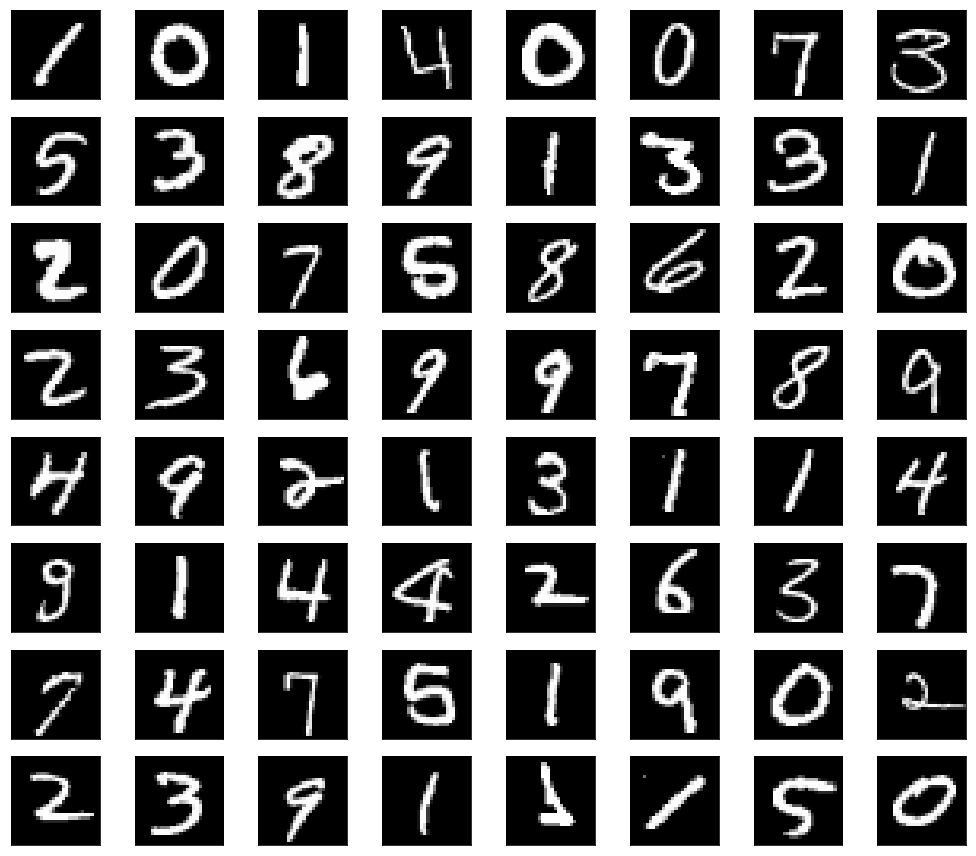

In [3]:
plt.figure(figsize=(14,12))
for digit_num in range(0,64):
    plt.subplot(8,8,digit_num+1)
    grid_data = X_train[digit_num].reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = 'gray' )
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [3]:
#对Isomap等计算量大的降维技术来说，4w+样本太多，随机抽取其中20%做实验
from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle
X_selected, X_val, y_selected, y_val = train_test_split(X_train, y_train, train_size = 0.2,random_state = 0)

# 原始输入的特征维数和样本数目
print('the shape of input: {}'.format(X_selected.shape))

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


the shape of input: (8400, 784)


## PCA

In [4]:
from sklearn.decomposition import PCA

start = time.time()

#PCA(n_components=None, copy=True, whiten=False, svd_solver=’auto’, tol=0.0, iterated_power=’auto’, random_state=None)
#默认参数，保留所有成分，可以根据每个分成能解释的方差，人工确定合适的成分数目n_components
pca = PCA()
print("PCA begin...");
pca.fit(X_selected)
    
# 降维 
X_pca = pca.transform(X_selected)

end = time.time()
print("PCA time elaps:{}".format(int(end-start)))

PCA begin...
PCA time elaps:0


Text(0,0.5,u'\u80fd\u89e3\u91ca\u7684\u65b9\u5dee\u7684\u6bd4\u4f8b')

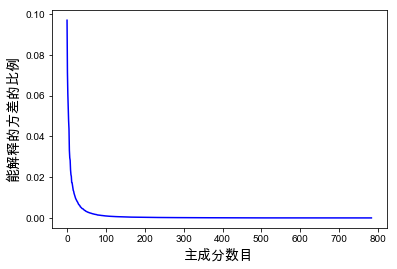

In [5]:
#explained_variance_：每个主成分能解释的方差的的百分比，即X的协方差矩阵的特征值
#explained_variance_ratio_：每个主成分能解释的方差的的百分比
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）
plt.plot( pca.explained_variance_ratio_, 'b-')

plt.xlabel(u"主成分数目", fontsize = 14)
plt.ylabel(u"能解释的方差的比例", fontsize = 14)

In [6]:
#主成分数目通常有三种方式：
#1. 直接确定主成分数目：如30
#2. 根据主成分的累计贡献率确定主成分数目，如累计贡献率大于85%。
#3. 肘部法（the elbow rule）：根据每个成分对应的特征值（解释的方差比例），寻找一个截止点（elbow），在该截止点，特征值显著下降。
# 根据上图，主成分数目可以取50-100.

Text(0,0.5,u'\u80fd\u89e3\u91ca\u7684\u7d2f\u8ba1\u65b9\u5dee\u7684\u6bd4\u4f8b')

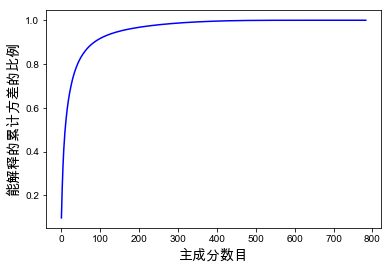

In [7]:
sum_explained_variance_ratio_ = np.zeros(X_selected.shape[1])

sum_explained_variance_ratio_[0] = pca.explained_variance_ratio_[0]
for i in range(1,X_selected.shape[1]): 
    sum_explained_variance_ratio_[i] = sum_explained_variance_ratio_[i-1] + pca.explained_variance_ratio_[i]
plt.plot( sum_explained_variance_ratio_, 'b-')

plt.xlabel(u"主成分数目", fontsize = 14)
plt.ylabel(u"能解释的累计方差的比例", fontsize = 14)

In [8]:
for i in range(0,X_selected.shape[1]): 
    if sum_explained_variance_ratio_[i] > 0.85:
        print("%d number of components explain %d variance", i+1, int(sum_explained_variance_ratio_[i]*100))
        break

('%d number of components explain %d variance', 59, 85)


In [9]:
for i in range(0,X_selected.shape[1]): 
    if sum_explained_variance_ratio_[i] > 0.90:
        print("%d number of components explain %d variance", i+1, int(sum_explained_variance_ratio_[i]*100))
        break

('%d number of components explain %d variance', 86, 90)


### 显示主成分

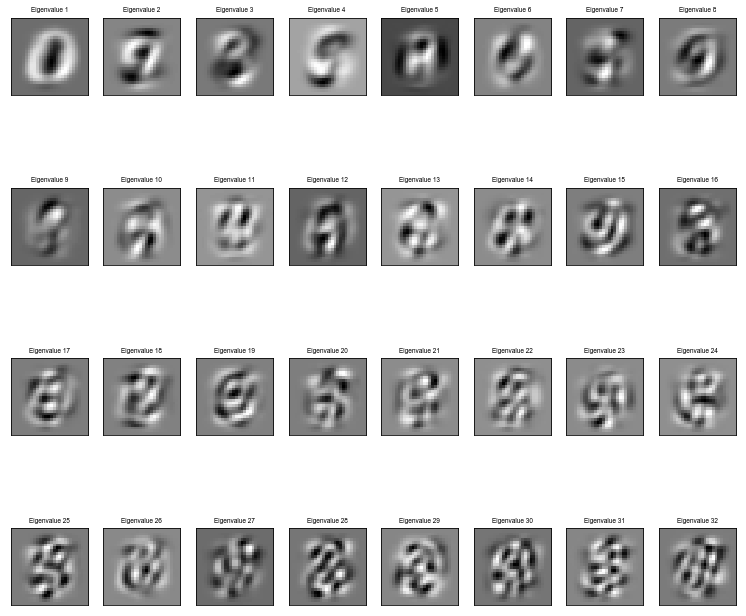

In [10]:
n_components = 32
eigenvalues = pca.components_

n_row = 4
n_col = 8

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap = 'gray' )
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

In [15]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize = 14)
    
    #plt.scatter(data[:, 0], data[:, 1],
    #        c=label, edgecolor='none', alpha=0.5,
    #        cmap=plt.cm.get_cmap('spectral', 10))
    plt.xlabel(u'成分1', fontsize = 14)
    plt.ylabel(u'成分2', fontsize = 14)
    #plt.colorbar();
    #return fig

In [12]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    df = pd.DataFrame(data, columns=['compoent-one', 'compoent-two'])
    #df['compoent-one'] = data[:, 0]
    #df['component-two'] = data[:, 1] 
    df['y'] = label
    
    fig = plt.figure()
    
    sns.scatterplot(
        x='compoent-one', y='component-two',
        hue='y',
        palette=sns.color_palette("hls", 10),
        data=df_subset,
        legend="full",
        alpha=0.3
        )

    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize = 14)
    
    #plt.scatter(data[:, 0], data[:, 1],
    #        c=label, edgecolor='none', alpha=0.5,
    #        cmap=plt.cm.get_cmap('spectral', 10))
    plt.xlabel(u'成分1', fontsize = 14)
    plt.ylabel(u'成分2', fontsize = 14)
    #plt.colorbar();
    #return fig

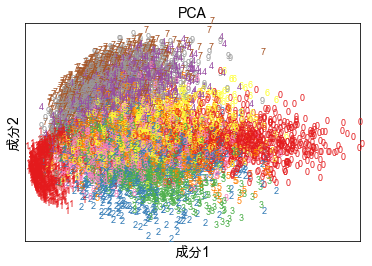

In [16]:
plot_embedding(X_pca[:,0:2], y_selected,u'PCA')

# Isomap

In [17]:
from sklearn.manifold import Isomap

start = time.time()

#Isomap(n_neighbors=5, n_components=2, eigen_solver=’auto’, tol=0, max_iter=None, path_method=’auto’, neighbors_algorithm=’auto’, n_jobs=None
isomap = Isomap(n_neighbors=30, n_components = 2)
print("Isomap begin...");
X_iso = isomap.fit_transform(X_selected)

end = time.time()
t = end - start
print("Isomap time elaps:{}".format(int(t)))

Isomap begin...
Isomap time elaps:210


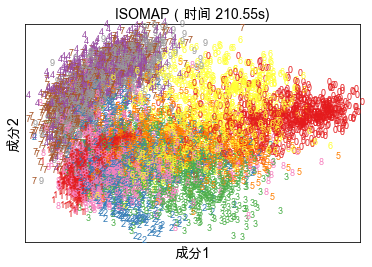

In [18]:
plot_embedding(X_iso, y_selected,u'ISOMAP（时间 %.2fs)' % t)

## LLE

In [27]:
from sklearn.manifold import LocallyLinearEmbedding

start = time.time()

#Isomap(n_neighbors=5, n_components=2, eigen_solver=’auto’, tol=0, max_iter=None, path_method=’auto’, neighbors_algorithm=’auto’, n_jobs=None
lle = LocallyLinearEmbedding(n_neighbors=30, n_components = 2)
print("LLE begin...");
X_lle = lle.fit_transform(X_selected)

end = time.time()

t = end - start
print("LLE time elaps:{}".format(int(t)))

LLE begin...
LLE time elaps:151


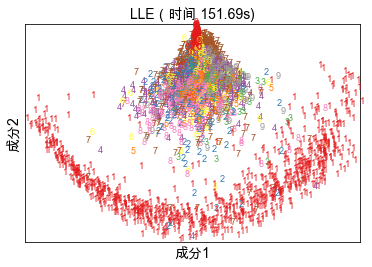

In [28]:
plot_embedding(X_lle, y_selected,u'LLE（时间 %.2fs)' % t)

## 拉普拉斯特征映射：SpectralEmbedding

In [30]:
from sklearn.manifold import SpectralEmbedding

start = time.time()

le = SpectralEmbedding(n_neighbors=30, n_components = 2)
print("spectral embedding begin...");
X_le = le.fit_transform(X_selected)

end = time.time()

t = end - start
print("spectral embedding time elaps:{}".format(int(t)))

spectral embedding begin...


/Users/qing/anaconda2/lib/python2.7/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


spectral embedding time elaps:134


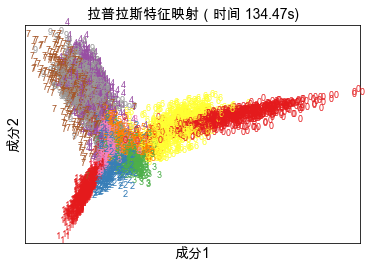

In [32]:
plot_embedding(X_le, y_selected, u'拉普拉斯特征映射（时间 %.2fs)' % t)

## T-NSE

In [16]:
from sklearn.manifold import TSNE

start = time.time()

tsne = TSNE( n_components = 2)
print("T-SNE begin...");
X_tsne = tsne.fit_transform(X_selected)

end = time.time()

t = end - start
print("T-NSE time elaps:{}".format(int(t)))

T-SNE begin...
T-NSE time elaps:312


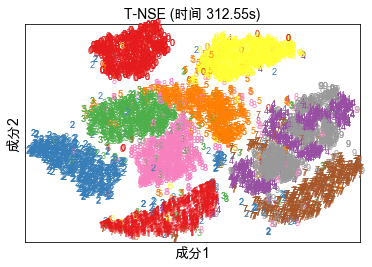

In [17]:
plot_embedding(X_tsne, y_selected,u'T-NSE (时间 %.2fs)' % t)

In [11]:
from sklearn.manifold import TSNE

start = time.time()

pca = PCA(n_components = 59)
X_pca = pca.fit_transform(X_selected)
    

tsne = TSNE( n_components = 2,init='pca')
print("TSNE with PCA begin...");
X_tsne = tsne.fit_transform(X_pca)

end = time.time()

t = end - start
print("TNSE with PCAtime elaps:{}".format(int(t)))

TSNE with PCA begin...
TNSE with PCAtime elaps:198


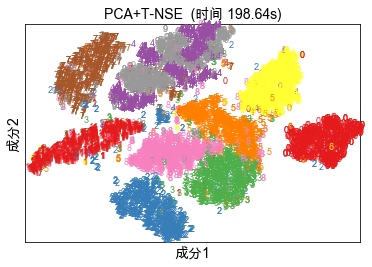

In [15]:
plot_embedding(X_tsne, y_selected,u'PCA+T-NSE  (时间 %.2fs)' % t)